<a href="https://colab.research.google.com/github/KavindaKGD/DL_Final_Assignment/blob/dev%2FMigara/LSTM_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!nvidia-smi

Wed Oct  8 02:59:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             31W /   70W |     202MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
# Basic libraries
import os, glob, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!unzip -q "/content/drive/MyDrive/street_building_dataset.zip" -d "/content/dataset"

replace /content/dataset/street_building_dataset/test/buildings/20057.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [22]:
import os
for root, dirs, files in os.walk("/content/dataset/street_building_dataset"):
    print(root, "->", len(files), "files")

/content/dataset/street_building_dataset -> 0 files
/content/dataset/street_building_dataset/train -> 0 files
/content/dataset/street_building_dataset/train/streets -> 2382 files
/content/dataset/street_building_dataset/train/buildings -> 2191 files
/content/dataset/street_building_dataset/test -> 0 files
/content/dataset/street_building_dataset/test/streets -> 501 files
/content/dataset/street_building_dataset/test/buildings -> 437 files


In [23]:
DATA_ROOT = "/content/dataset/street_building_dataset"

In [24]:
IMG_H, IMG_W = 150, 150
BATCH_SIZE = 32

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/train",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/street_building_dataset/test",
    labels="inferred",
    label_mode="int",
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 4573 files belonging to 2 classes.
Found 938 files belonging to 2 classes.
Classes: ['buildings', 'streets']


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

def rgb_to_seq(images, labels):
    images = tf.image.rgb_to_grayscale(images)
    images = tf.cast(images, tf.float32) / 255.0
    images = tf.squeeze(images, axis=-1)  # (batch, H, W)
    return images, labels

train_ds = train_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(rgb_to_seq, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

In [27]:
from tensorflow.keras import layers, models, Input

timesteps = IMG_H
features = IMG_W

inputs = Input(shape=(timesteps, features))
x = layers.LSTM(128)(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       142,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,169 (590.50 KB)

 Trainable params: 151,169 (590.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
callbacks = [
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_lstm.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5730 - loss: 0.6707

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5732 - loss: 0.6706 - val_accuracy: 0.6535 - val_loss: 0.6355
Epoch 2/20
138/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6378 - loss: 0.6467

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6373 - loss: 0.6468 - val_accuracy: 0.6578 - val_loss: 0.6492
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6304 - loss: 0.6429 - val_accuracy: 0.6397 - val_loss: 0.6391
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6126 - loss: 0.6586 - val_accuracy: 0.6087 - val_loss: 0.6499
Epoch 5/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6208 - loss: 0.6442

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6210 - loss: 0.6440 - val_accuracy: 0.6951 - val_loss: 0.5903
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6888 - loss: 0.5972 - val_accuracy: 0.6780 - val_loss: 0.6060
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6909 - loss: 0.6027

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6909 - loss: 0.6027 - val_accuracy: 0.6994 - val_loss: 0.6074
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6763 - loss: 0.6033 - val_accuracy: 0.6770 - val_loss: 0.6090
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6944 - loss: 0.5890 - val_accuracy: 0.6674 - val_loss: 0.6019
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6790 - loss: 0.6081

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6791 - loss: 0.6080 - val_accuracy: 0.7036 - val_loss: 0.5917
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7070 - loss: 0.5809 - val_accuracy: 0.7015 - val_loss: 0.5888
Epoch 12/20
138/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7102 - loss: 0.5769

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7096 - loss: 0.5773 - val_accuracy: 0.7090 - val_loss: 0.5770
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7240 - loss: 0.5659 - val_accuracy: 0.7079 - val_loss: 0.5745
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7205 - loss: 0.5653

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7204 - loss: 0.5653 - val_accuracy: 0.7281 - val_loss: 0.5647
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7364 - loss: 0.5516 - val_accuracy: 0.7249 - val_loss: 0.5532
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7378 - loss: 0.5398 - val_accuracy: 0.7217 - val_loss: 0.5604
Epoch 17/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7332 - loss: 0.5403

143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7331 - loss: 0.5403 - val_accuracy: 0.7356 - val_loss: 0.5507
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7302 - loss: 0.5331

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7302 - loss: 0.5331 - val_accuracy: 0.7399 - val_loss: 0.5429
Epoch 19/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7428 - loss: 0.5275 - val_accuracy: 0.7377 - val_loss: 0.5455
Epoch 20/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7525 - loss: 0.5224 - val_accuracy: 0.7377 - val_loss: 0.5294


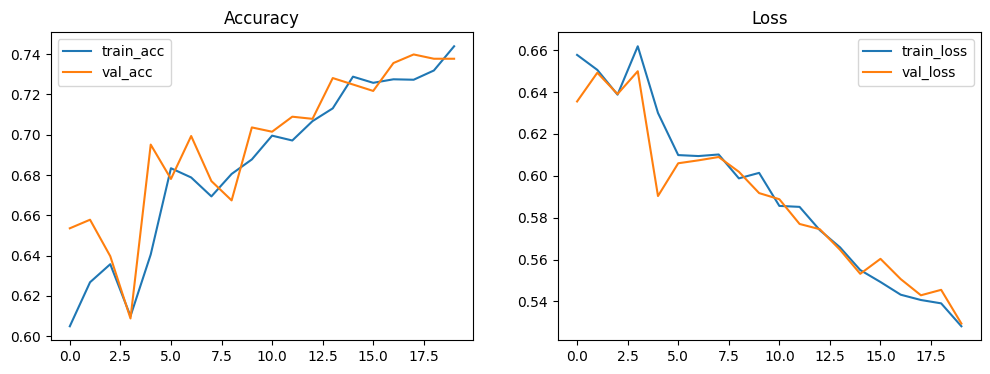

In [32]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.show()

In [33]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.3f}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7328 - loss: 0.5759
Test Accuracy: 0.738


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

   buildings       0.72      0.72      0.72       437
     streets       0.76      0.75      0.75       501

    accuracy                           0.74       938
   macro avg       0.74      0.74      0.74       938
weighted avg       0.74      0.74      0.74       938



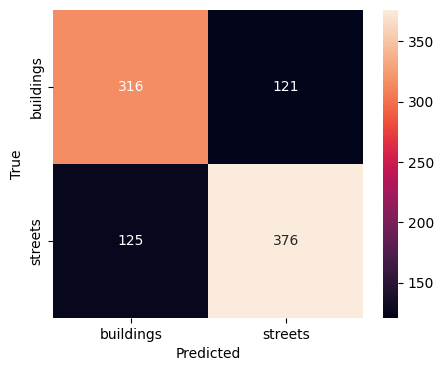

In [34]:
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = (y_prob.flatten() >= 0.5).astype(int)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

In [40]:
model.save("/content/drive/MyDrive/best_lstm_street_building.keras")

In [49]:
!unzip -q "/content/dataset/pred.zip" -d "/content/dataset/pred"

In [50]:
pred_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/pred/pred",
    labels=None,              # unlabeled
    image_size=(IMG_H, IMG_W),
    batch_size=BATCH_SIZE,
    shuffle=False
)

pred_ds = pred_ds.map(lambda x: tf.image.rgb_to_grayscale(x)/255.0).cache()

Found 7301 files.


In [51]:
pred_prob = model.predict(pred_ds)
pred_class = (pred_prob.flatten() >= 0.5).astype(int)  # 0 = first class, 1 = second class

# Convert numeric predictions to class names
pred_labels = [class_names[i] if i < len(class_names) else "unknown" for i in pred_class]

for i, label in enumerate(pred_labels[:50]):  # show first 50
    print(f"Image {i+1}: {label}")

229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step
Image 1: buildings
Image 2: buildings
Image 3: streets
Image 4: buildings
Image 5: buildings
Image 6: buildings
Image 7: buildings
Image 8: streets
Image 9: buildings
Image 10: buildings
Image 11: streets
Image 12: buildings
Image 13: buildings
Image 14: buildings
Image 15: streets
Image 16: buildings
Image 17: buildings
Image 18: buildings
Image 19: streets
Image 20: buildings
Image 21: streets
Image 22: streets
Image 23: streets
Image 24: streets
Image 25: buildings
Image 26: streets
Image 27: streets
Image 28: buildings
Image 29: streets
Image 30: buildings
Image 31: buildings
Image 32: streets
Image 33: streets
Image 34: buildings
Image 35: buildings
Image 36: buildings
Image 37: streets
Image 38: buildings
Image 39: streets
Image 40: buildings
Image 41: buildings
Image 42: buildings
Image 43: buildings
Image 44: buildings
Image 45: buildings
Image 46: buildings
Image 47: streets
Image 48: buildings
Image 49: streets
Image 50: buildings


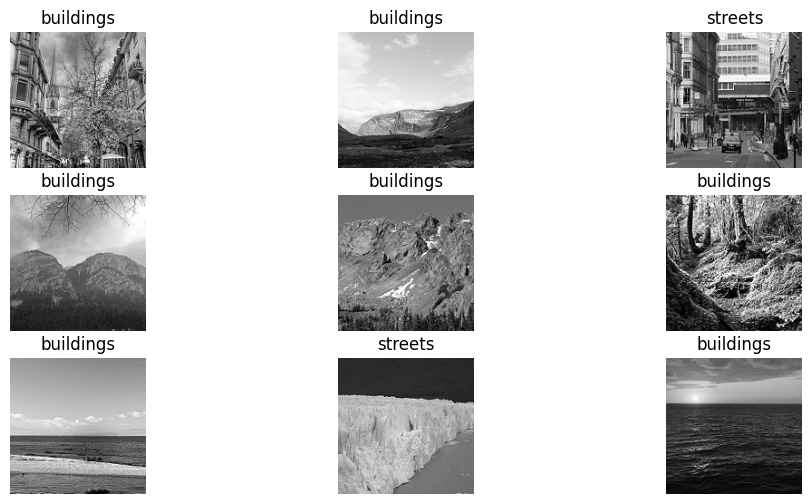

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for images in pred_ds.take(1):
    imgs = images.numpy()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i].squeeze(), cmap='gray')
    plt.title(pred_labels[i])
    plt.axis('off')
plt.show()

In [55]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

IMG_H, IMG_W = 150, 150
class_names = ['streets', 'buildings']

def predict_image(image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(IMG_H, IMG_W))
    img_array = img_to_array(img)
    img_array = tf.image.rgb_to_grayscale(img_array)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict
    pred_prob = model.predict(img_array)[0][0]
    pred_class = 1 if pred_prob >= 0.5 else 0
    print(f"Predicted class: {class_names[pred_class]} (probability: {pred_prob:.3f})")

# Example usage:
predict_image("/content/dataset/pred/pred/72.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
Predicted class: buildings (probability: 0.910)
